In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
from scipy import misc
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import csgraph
from scipy import linalg
from pysheds.grid import Grid
from scipy import ndimage
from matplotlib import colors
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
from matplotlib.collections import LineCollection
import matplotlib.gridspec as gridspec

%matplotlib inline

In [2]:
sns.set_palette('husl', 2)

In [3]:
grid = Grid.from_raster('/home/mdbartos/Downloads/n30w100_dir/n30w100_dir',
                 data_name='dir')

In [4]:
grid.read_raster('/home/mdbartos/Downloads/n30w100_con/n30w100_con',
                 data_name='dem')

In [5]:
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

# Specify pour point
x, y = -97.294167, 32.73750

# Delineate the catchment
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label')
# Clip the bounding box to the catchment
grid.clip_to('catch', precision=5)

grid.accumulation(data='catch', dirmap=dirmap, pad_inplace=False, out_name='acc')

In [6]:
profiles, connections = grid.extract_profiles('catch', grid.acc > 25)

In [7]:
geom = grid.extract_river_network('catch', grid.acc > 25)

# Lo Diffusion + advection

In [8]:
dx = 60. * (np.asarray([profile.size for profile in profiles]) + 1)
n = max(max(connections.keys()), max(connections.values())) + 1
s = np.ones(n)
I = np.eye(n)
u = 1.0*np.ones(n)
D = (u * dx / 10).mean()*np.ones(n)
dt = 1
I[0, 0] = 0

U = np.zeros((n, n))
W = np.zeros((n, n))

for i, j in connections.items():
    # Confirmed as i
    U[j, i] = u[i] * dt / dx[i]
    W[i, j] = u[i] * dt / dx[i]
    
V = np.diag(W @ s)

X = np.zeros((n, n))

for i, j in connections.items():
    X[i, j] = 2 / (dx[i] + dx[j])
    X[j, i] = 2 / (dx[i] + dx[j])
    
Y = np.diag(X @ s)

Z = np.diag(D * dt / dx)
S = (U - V) - Z @ (Y - X) + I

In [9]:
np.imag(np.linalg.eig(S)[0]).max(), np.imag(np.linalg.eig(S)[0]).min(), np.real(np.linalg.eig(S)[0]).max(), np.real(np.linalg.eig(S)[0]).min()

(0.0, 0.0, 0.9997196165216445, -0.0027755206889173286)

In [10]:
C = np.eye(n)
ns = 11

W_os = []
for i in range(len(S)):
    W_o_i = linalg.solve_discrete_lyapunov(S.T, I[[i]].T @ I[[i]])
    W_os.append(W_o_i)

Ws = []
ss = []
ns = 11

for i in range(ns):
    rs = np.asarray([np.linalg.matrix_rank(w + sum(Ws)) for w in W_os])
    ix = np.argmax(rs)
    ss.append(ix)
    Ws.append(W_os[ix])

In [11]:
W_c = linalg.solve_discrete_lyapunov(S, C)
st = np.argsort(np.diag(W_c))[::-1][:ns]

In [12]:
W_o = linalg.solve_discrete_lyapunov(S.T, C)

In [13]:
np.random.seed(0)
x0 = np.ones(S.shape[0])

In [14]:
from numba import njit

In [15]:
sr = np.asarray([  1, 128, 136,  52,  64,  92, 194,   9, 143, 161, 191,  13,  71,
       15, 125,  77, 141, 198,  58, 150, 102,  12,  88, 164, 204,   2,
       70,  87, 159, 177, 197,  22])

In [16]:
@njit(fastmath=True)
def compute_multi_x0s(X0, S, C, T):
    Ac = np.eye(S.shape[0])
    Wo_r = np.zeros(S.shape)
    R_r = np.zeros(X0.shape)
    X0_hat = np.zeros(X0.shape)
    m = X0.shape[0]
    for _ in range(T):
        AC = C @ Ac
        Wo_r += (AC.T @ AC)
        for i in range(m):
            y = AC @ X0[i]
            R_r[i] += (AC.T @ y)
        Ac = S @ Ac
    Wo_r_inv = np.linalg.pinv(Wo_r)
    for i in range(m):
        X0_hat[i] = (Wo_r_inv @ R_r[i])
    return X0_hat

In [17]:
C = np.eye(S.shape[0])[sr[:11]]
X0 = np.vstack([x0, x0, x0, x0])

In [18]:
%time x0_hats = compute_multi_x0s(X0, S, C, 4000)

CPU times: user 24.7 s, sys: 6.51 s, total: 31.2 s
Wall time: 7.77 s


In [19]:
l, u = np.linalg.eigh(W_o)

In [20]:
X0 = (u.T).copy() # Copy to ensure contiguous array

In [21]:
start = time.time()
x0_hats = compute_multi_x0s(X0, S, C, 4000)
end = time.time()
print(end - start, ' s')

8.401494979858398  s


In [22]:
C = np.eye(len(S))
X0_hats_r = {}

for i in range(1, len(sr)):
    sensors = sr[:i].tolist()
    Ci = C[sensors]
    start = time.time()
    x0_hats_i = compute_multi_x0s(X0, S, Ci, 3600)
    end = time.time()
    print(f'{i}: ', end - start, ' s')
    X0_hats_r[i] = x0_hats_i

N:  5.268695592880249  s
N:  5.600111961364746  s
N:  6.089126110076904  s
N:  5.897075891494751  s
N:  6.233657121658325  s


In [18]:
C = np.eye(S.shape[0])[ss]

@njit(fastmath=True)
def compute_multi_x0s(X0, S, C, T):
    Ac = np.eye(S.shape[0])
    Wo_r = np.zeros(S.shape)
    R_r = np.zeros(X0.shape)
    X0_hat = np.zeros(X0.shape)
    m = X0.shape[0]
    for _ in range(T):
        Wo_r += (Ac.T @ C.T @ C @ Ac)
        for i in range(m):
            y = C @ Ac @ X0[i]
            R_r[i] += (Ac.T @ C.T @ y)
        Ac = S @ Ac
    Wo_r_inv = np.linalg.pinv(Wo_r)
    for i in range(m):
        X0_hat[i] = (Wo_r_inv @ R_r[i])
    return X0_hat

In [19]:
X0 = np.vstack([x0, x0, x0, x0])

In [20]:
x0_hats = compute_multi_x0s(X0, S, C, 4000)

In [66]:
%time x0_hats = compute_multi_x0s(X0, S, C, 4000)

CPU times: user 46.2 s, sys: 12.6 s, total: 58.8 s
Wall time: 9.9 s


In [21]:
l, u = np.linalg.eigh(W_o)

In [22]:
X0 = (u.T).copy() # Copy to ensure contiguous array

In [23]:
start = time.time()
x0_hats = compute_multi_x0s(X0, S, C, 4000)
end = time.time()
print(end - start, ' s')

234.84295296669006  s


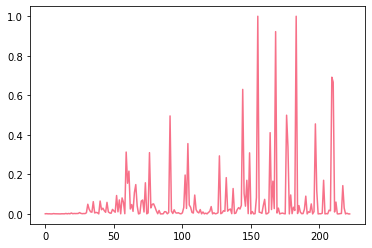

In [24]:
plt.plot(((x0_hats - X0)**2).sum(axis=1)[::-1])

In [25]:
Adj = np.zeros((n, n))

for i, j in connections.items():
    # Confirmed as i
    Adj[j, i] = 1
    Adj[i, j] = 1
    
Lap = sparse.csgraph.laplacian(Adj)

In [26]:
L, U = np.linalg.eigh(Lap)

In [27]:
X0 = (U.T).copy() # Copy to ensure contiguous array

In [28]:
start = time.time()
x0_hats = compute_multi_x0s(X0, S, C, 4000)
end = time.time()
print(end - start, ' s')

236.69770002365112  s


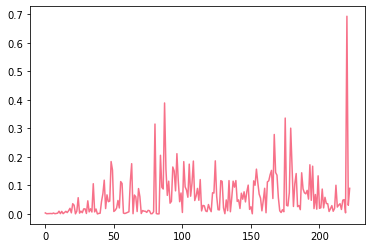

In [29]:
plt.plot(((x0_hats - X0)**2).sum(axis=1))

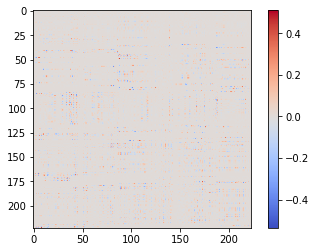

In [82]:
plt.imshow((x0_hats - X0), cmap='coolwarm')
plt.colorbar()

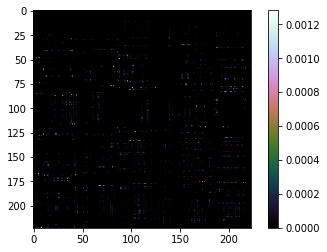

In [84]:
plt.imshow((x0_hats - X0)**2 / X0.shape[1], cmap='cubehelix')
plt.colorbar()

In [17]:
C = np.eye(S.shape[0])[ss]

@njit(fastmath=True)
def compute_x0s(x0, S, C, T):
    Ac = np.eye(S.shape[0])
    Wo_r = np.zeros(S.shape)
    R_r = np.zeros(x0.size)
    for _ in range(T):
        y = C @ Ac @ x0
        Wo_r += (Ac.T @ C.T @ C @ Ac)
        R_r += (Ac.T @ C.T @ y)
        Ac = S @ Ac
    x0_hat_r = (np.linalg.pinv(Wo_r) @ R_r)
    return x0_hat_r

In [26]:
%time x0_hats = compute_x0s(x0, S, C, 4000)

CPU times: user 39.6 s, sys: 9.74 s, total: 49.4 s
Wall time: 8.97 s


In [92]:
150 * 32 / 3600

1.3333333333333333